Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [ ]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [ ]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [ ]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [ ]:
df.tail()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
23035,4,OTHER,01 ONE FAMILY DWELLINGS,1,10965,276,NaN,A5,111-17 FRANCIS LEWIS BLVD,NaN,11429.0,1.0,0.0,1.0,"1,800",1224.0,1945.0,1,A5,510000,04/30/2019
23036,4,OTHER,09 COOPS - WALKUP APARTMENTS,2,169,29,NaN,C6,"45-14 43RD STREET, 3C",NaN,11104.0,0.0,0.0,0.0,0,0.0,1929.0,2,C6,355000,04/30/2019
23037,4,OTHER,10 COOPS - ELEVATOR APARTMENTS,2,131,4,NaN,D4,"50-05 43RD AVENUE, 3M",NaN,11377.0,0.0,0.0,0.0,0,0.0,1932.0,2,D4,375000,04/30/2019
23038,4,OTHER,02 TWO FAMILY DWELLINGS,1,8932,18,NaN,S2,91-10 JAMAICA AVE,NaN,11421.0,2.0,1.0,3.0,"2,078",2200.0,1931.0,1,S2,1100000,04/30/2019
23039,4,OTHER,12 CONDOS - WALKUP APARTMENTS,2,1216,1161,NaN,R2,"61-05 39TH AVENUE, F5",F5,11377.0,1.0,0.0,85.0,"15,151",854.0,1927.0,2,R2,569202,04/30/2019


In [ ]:
# data clean up using dropna
df = df.dropna(axis=0)
df

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE


In [ ]:
df = df.dropna(axis=1)
df

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,BLOCK,LOT,ADDRESS,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,716,1246,"447 WEST 18TH STREET, PH12A",2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,812,68,144 WEST 37TH STREET,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,839,69,40 WEST 38TH STREET,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,592,1041,"1 SHERIDAN SQUARE, 8C",2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,1379,1402,"20 EAST 65TH STREET, B",2,R1,0,01/01/2019
...,...,...,...,...,...,...,...,...,...,...
23035,4,OTHER,01 ONE FAMILY DWELLINGS,10965,276,111-17 FRANCIS LEWIS BLVD,1,A5,510000,04/30/2019
23036,4,OTHER,09 COOPS - WALKUP APARTMENTS,169,29,"45-14 43RD STREET, 3C",2,C6,355000,04/30/2019
23037,4,OTHER,10 COOPS - ELEVATOR APARTMENTS,131,4,"50-05 43RD AVENUE, 3M",2,D4,375000,04/30/2019
23038,4,OTHER,02 TWO FAMILY DWELLINGS,8932,18,91-10 JAMAICA AVE,1,S2,1100000,04/30/2019


In [ ]:
# filtering to use a subset of the data showing only:
# BULDING CLASS CATEGORY == 01 ONE FAMILY DWELLINGS &
# SALE PRICE BETWEEN $100,000.01 - $1,999,999.99
df = df[(df['BUILDING_CLASS_CATEGORY']=='01 ONE FAMILY DWELLINGS') &
        (df['SALE_PRICE']<2000000) & (df['SALE_PRICE']>100000)]

df.tail()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,BLOCK,LOT,ADDRESS,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
23029,4,OTHER,01 ONE FAMILY DWELLINGS,13215,3,244-15 135 AVENUE,1,A2,635000,04/30/2019
23031,4,OTHER,01 ONE FAMILY DWELLINGS,11612,73,10919 132ND STREET,1,A1,514000,04/30/2019
23032,4,OTHER,01 ONE FAMILY DWELLINGS,11808,50,135-24 122ND STREET,1,A0,635000,04/30/2019
23033,4,OTHER,01 ONE FAMILY DWELLINGS,12295,23,134-34 157TH STREET,1,A1,545000,04/30/2019
23035,4,OTHER,01 ONE FAMILY DWELLINGS,10965,276,111-17 FRANCIS LEWIS BLVD,1,A5,510000,04/30/2019


In [ ]:
# checking data type for SALE DATE to start a train/test split
df['SALE_DATE'].sort_values()

44       01/01/2019
61       01/01/2019
193      01/02/2019
185      01/02/2019
184      01/02/2019
            ...    
22944    04/30/2019
22929    04/30/2019
23033    04/30/2019
22999    04/30/2019
23035    04/30/2019
Name: SALE_DATE, Length: 3151, dtype: object

In [ ]:
# changing data type format of SALE DATE to DATETIME
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
cutoff = pd.to_datetime('2019-04-01')
train = df[df.SALE_DATE < cutoff]
test = df[df.SALE_DATE >= cutoff]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
train.describe(include='number')

,BLOCK,LOT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,2507.000000,2507.000000,2507.0,2.507000e+03
mean,6758.303949,75.778221,1.0,6.215737e+05
std,3975.909029,157.531138,0.0,2.916072e+05
min,21.000000,1.000000,1.0,1.040000e+05
25%,3837.500000,21.000000,1.0,4.405000e+05
50%,6022.000000,42.000000,1.0,5.600000e+05
75%,9888.500000,70.000000,1.0,7.500000e+05
max,16350.000000,2720.000000,1.0,1.955000e+06


In [ ]:
train.describe(exclude='number')

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,ADDRESS,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,2507,2507,2507,2507,2507,2507
unique,5,6,1,2497,11,68
top,4,OTHER,01 ONE FAMILY DWELLINGS,294 FREEBORN STREET,A1,2019-01-31 00:00:00
freq,1204,2382,2507,2,919,78
first,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,2019-03-30 00:00:00


In [ ]:
# One-hot encoding of categorical features - NEIGHBORHOOD
# check for column information
train['BUILDING_CLASS_AT_TIME_OF_SALE'].value_counts()

A1    919
A5    779
A2    413
A9    193
A0     67
S1     39
A3     38
A8     31
A6     14
A4     13
S0      1
Name: BUILDING_CLASS_AT_TIME_OF_SALE, dtype: int64

In [ ]:
target = 'SALE_PRICE'
high_cardinality = ['ADDRESS', 'SALE_DATE' ]
features = train.columns.drop([target] + high_cardinality)

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

# checking dataset prior to encoding
X_train.tail()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,BLOCK,LOT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE
18129,5,OTHER,01 ONE FAMILY DWELLINGS,4081,44,1,A2
18130,5,OTHER,01 ONE FAMILY DWELLINGS,2373,201,1,A5
18132,5,OTHER,01 ONE FAMILY DWELLINGS,1132,42,1,A1
18134,5,OTHER,01 ONE FAMILY DWELLINGS,3395,37,1,A2
18147,4,OTHER,01 ONE FAMILY DWELLINGS,11159,11,1,A0


In [ ]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

# dataset after encoding
X_train

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,BLOCK,LOT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
44,1,0,0,0,0,1,0,0,0,0,0,1,5495,801,1,1,0,0,0,0,0,0,0,0,0,0
61,0,1,0,0,0,1,0,0,0,0,0,1,7918,72,1,0,1,0,0,0,0,0,0,0,0,0
78,0,0,1,0,0,1,0,0,0,0,0,1,4210,19,1,0,1,0,0,0,0,0,0,0,0,0
108,1,0,0,0,0,1,0,0,0,0,0,1,5212,69,1,0,1,0,0,0,0,0,0,0,0,0
111,1,0,0,0,0,1,0,0,0,0,0,1,7930,121,1,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18129,0,0,0,1,0,1,0,0,0,0,0,1,4081,44,1,0,0,0,0,1,0,0,0,0,0,0
18130,0,0,0,1,0,1,0,0,0,0,0,1,2373,201,1,0,0,1,0,0,0,0,0,0,0,0
18132,0,0,0,1,0,1,0,0,0,0,0,1,1132,42,1,0,1,0,0,0,0,0,0,0,0,0
18134,0,0,0,1,0,1,0,0,0,0,0,1,3395,37,1,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
# feature selection with SelectKBest

def engineer_features(X):
  X = X.copy()

  feature_cols = ['BUILDING_CLASS_AT_TIME_OF_SALE_A0', 'BUILDING_CLASS_AT_TIME_OF_SALE_A1', 
                  'BUILDING_CLASS_AT_TIME_OF_SALE_A2', 'BUILDING_CLASS_AT_TIME_OF_SALE_A3',
                  'BUILDING_CLASS_AT_TIME_OF_SALE_A4', 'BUILDING_CLASS_AT_TIME_OF_SALE_A5',
                  'BUILDING_CLASS_AT_TIME_OF_SALE_A6', 'BUILDING_CLASS_AT_TIME_OF_SALE_A8',
                  'BUILDING_CLASS_AT_TIME_OF_SALE_A9', 'BUILDING_CLASS_AT_TIME_OF_SALE_S0',
                  'BUILDING_CLASS_AT_TIME_OF_SALE_S1']
  X['feature_count'] = X[feature_cols].sum(axis=1)

  # Single Family Building (Building Code A0-A9)
  X['SINGLE_FAMILY'] = (X['BUILDING_CLASS_AT_TIME_OF_SALE_A1']==1) | (X['BUILDING_CLASS_AT_TIME_OF_SALE_A2']==1) | (X['BUILDING_CLASS_AT_TIME_OF_SALE_A3']==1) | (X['BUILDING_CLASS_AT_TIME_OF_SALE_A4']==1) | (X['BUILDING_CLASS_AT_TIME_OF_SALE_A5']==1) | (X['BUILDING_CLASS_AT_TIME_OF_SALE_A6']==1) | (X['BUILDING_CLASS_AT_TIME_OF_SALE_A8']==1) | (X['BUILDING_CLASS_AT_TIME_OF_SALE_A9']==1) | (X['BUILDING_CLASS_AT_TIME_OF_SALE_A0']==1)

  X['SINGLE_FAMILY'] = (X['BUILDING_CLASS_AT_TIME_OF_SALE_A1']==1) & (X['BUILDING_CLASS_AT_TIME_OF_SALE_A2']==1) & (X['BUILDING_CLASS_AT_TIME_OF_SALE_A3']==1) & (X['BUILDING_CLASS_AT_TIME_OF_SALE_A4']==1) & (X['BUILDING_CLASS_AT_TIME_OF_SALE_A5']==1) & (X['BUILDING_CLASS_AT_TIME_OF_SALE_A6']==1) & (X['BUILDING_CLASS_AT_TIME_OF_SALE_A8']==1) & (X['BUILDING_CLASS_AT_TIME_OF_SALE_A9']==1) & (X['BUILDING_CLASS_AT_TIME_OF_SALE_A0']==1)

  # Building with multiple use (Family & Stores/Offices)
  X['MULTIPLE_USE'] = (X['BUILDING_CLASS_AT_TIME_OF_SALE_S0']==1) | (X['BUILDING_CLASS_AT_TIME_OF_SALE_S1']==1)

  # Building with multiple use (Family & Stores/Offices)
  X['MULTIPLE_USE'] = (X['BUILDING_CLASS_AT_TIME_OF_SALE_S0']==1) & (X['BUILDING_CLASS_AT_TIME_OF_SALE_S1']==1)

  return X_test

X_train = engineer_features(X_train)
X_test = engineer_features(X_test)



KeyError: ignored

In [ ]:
features = X_train.columns
n = len(features)
n

26

In [ ]:
from math import factorial

def n_choose_k(n, k):
  return factorial(n)/(factorial(k)*factorial(n-k))

combinations = sum(n_choose_k(n,k) for k in range(1,n+1))
print(f'{combinations:,.0f}')

67,108,863


In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(k=15)
score_func=f_regression
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

X_train.shape, X_test.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 4 11 14 25] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


((2507, 26), (644, 26))

In [ ]:

X_train_selected

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [ ]:
# identify features selected

selected_mask = selector.get_support()
selected_mask
all_names = X_train.columns
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print('\n')
print('Features not selected:')
for name in unselected_names:
    print(name)

Features selected:
BOROUGH_4
BOROUGH_5
BOROUGH_1
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FOREST HILLS
NEIGHBORHOOD_BOROUGH PARK
NEIGHBORHOOD_ASTORIA
LOT
BUILDING_CLASS_AT_TIME_OF_SALE_A5
BUILDING_CLASS_AT_TIME_OF_SALE_A3
BUILDING_CLASS_AT_TIME_OF_SALE_S1
BUILDING_CLASS_AT_TIME_OF_SALE_A4
BUILDING_CLASS_AT_TIME_OF_SALE_A6
BUILDING_CLASS_AT_TIME_OF_SALE_A8
BUILDING_CLASS_AT_TIME_OF_SALE_S0


Features not selected:
BOROUGH_3
BOROUGH_2
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_BEDFORD STUYVESANT
BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS
BLOCK
TAX_CLASS_AT_TIME_OF_SALE
BUILDING_CLASS_AT_TIME_OF_SALE_A9
BUILDING_CLASS_AT_TIME_OF_SALE_A1
BUILDING_CLASS_AT_TIME_OF_SALE_A0
BUILDING_CLASS_AT_TIME_OF_SALE_A2


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

import numpy as np
np.seterr(divide='ignore', invalid='ignore')

for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test Mean Absolute Error: ${mae:,.0f} \n')

NameError: ignored

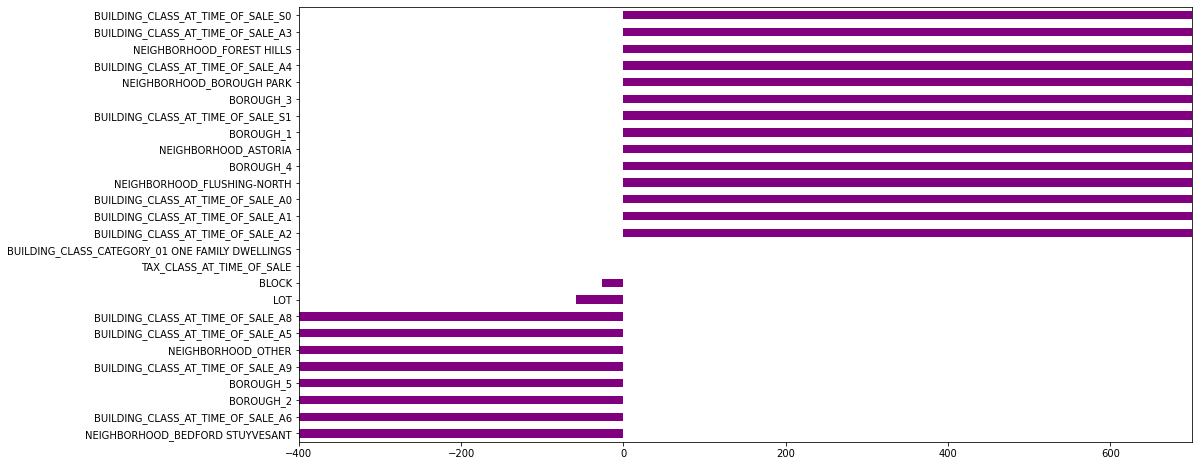

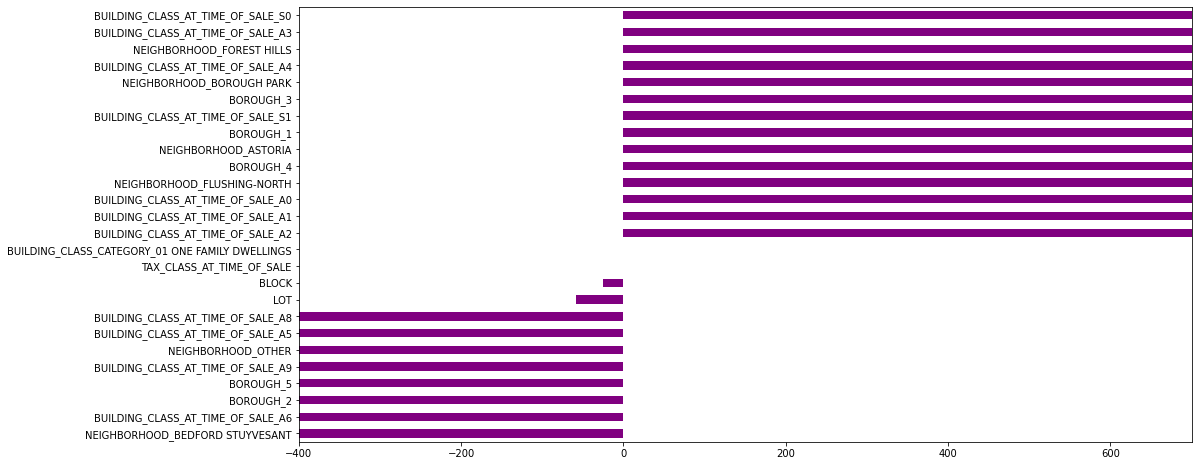

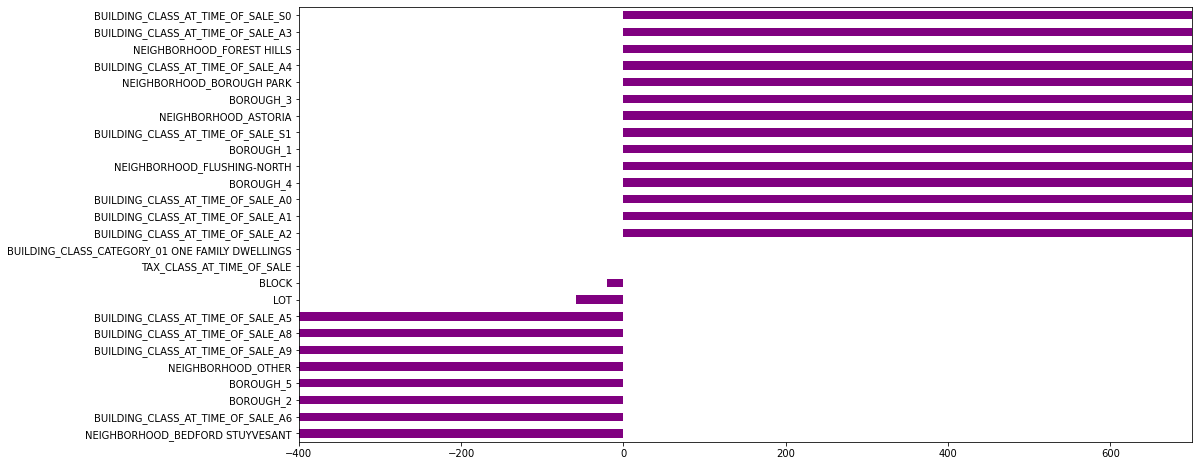

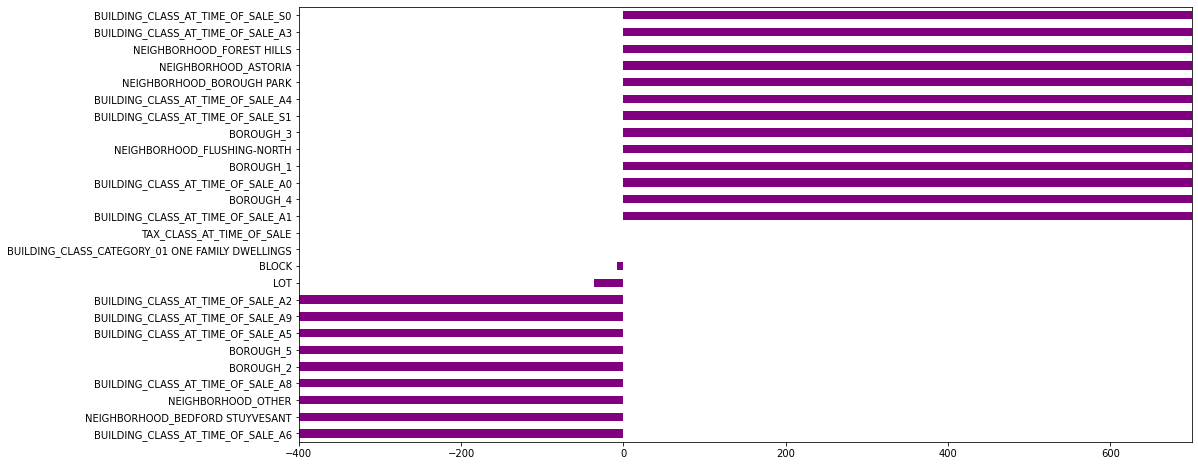

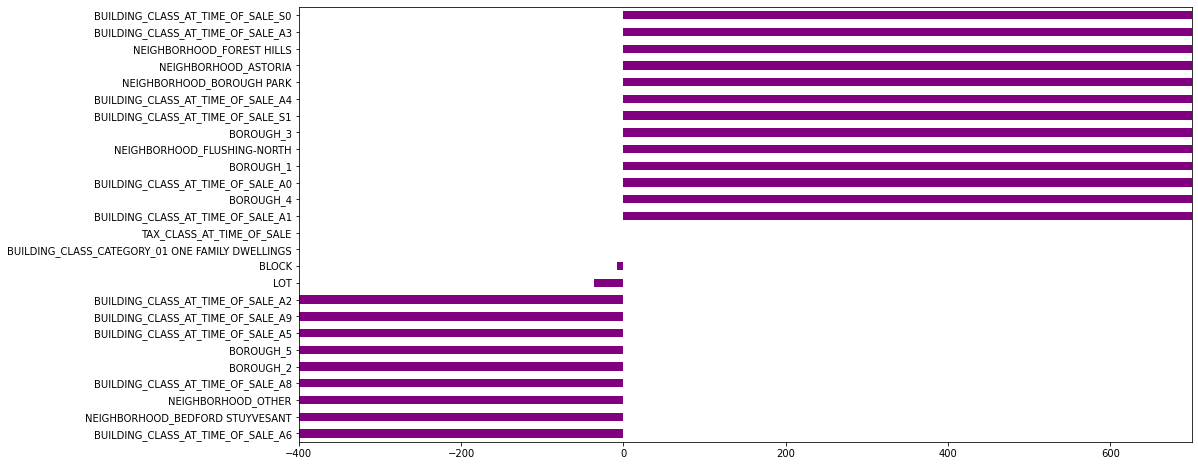

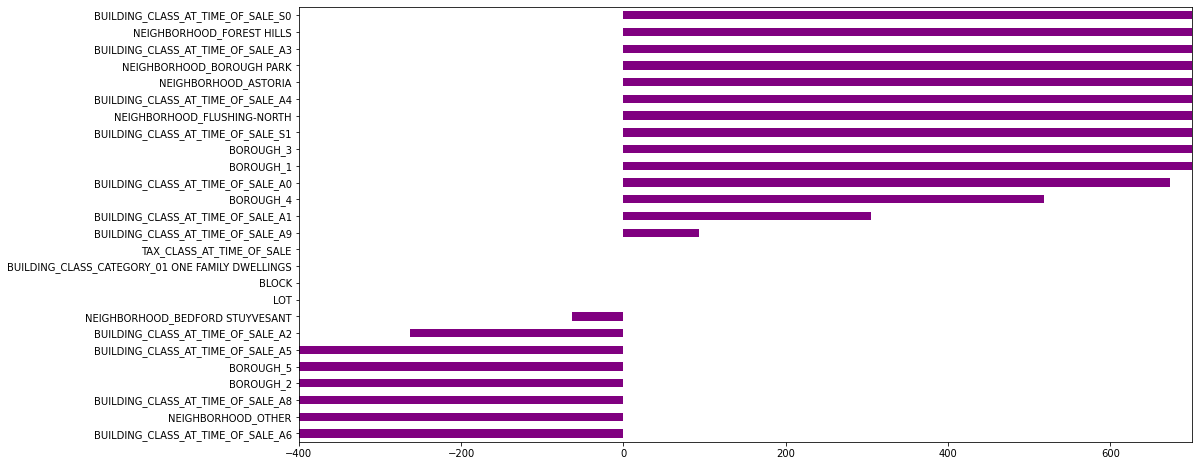

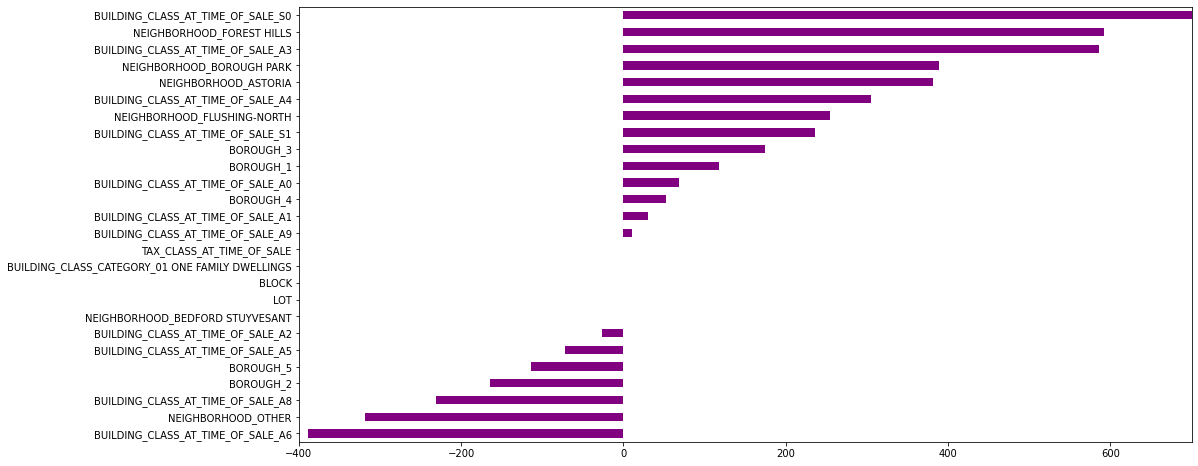

In [ ]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

for alpha in [0.001, 0.01, 0.1, 1.0, 1, 100.0, 1000.0]:
    
    # Fit Ridge Regression model
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Get Test MAE
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    # Plot coefficients
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='purple')
    plt.xlim(-400,700)
    plt.show()